# QGraf

In [1]:
from smpl import io

In [2]:
from pyfeyn2.interface import qgraf
import itertools as it
import re

In [3]:
style = "tmp.sty"
model ="tmp.model"
dat  = "tmp.dat"
output = "output.out"

def multiple_replace(string, rep_dict):
    pattern = re.compile("|".join([re.escape(k) for k in sorted(rep_dict,key=len,reverse=True)]), flags=re.DOTALL)
    return pattern.sub(lambda x: rep_dict[x.group(0)], string)



raw_model = r"""
* https://porthos.tecnico.ulisboa.pt/CTQFT/node9.html


*                  Higgs

*  [H,H,+]

*   leptons

  [e,E,-]

*                  neutrinos

  [n,N,-]

*              quarks

* [u,U,-]
* [d,D,-]


*      photon, W-boson, Z-boson, gluon

  [A,A,+]
  [WM,WP,+]
  [Z,Z,+]
* [g,g,+]

*                 cubic vertices


  [WP,WM,A]
  [WP,WM,Z]
* [g,g,g]


*  [WP,WM,H]
*  [Z,Z,H]
*  [H,H,H]

* yukawa

*  [E1,e1,H]
*  [E2,e2,H]
*  [E3,e3,H]

* [U,u,H]
* [D,d,H]

* fermion - gauge boson

  [E,e,A]

  [E,e,Z]

  [N,n,Z]

  [N,e,WP]

  [E,n,WM]

* [U,u,A]
* [D,d,A]

* [U,u,Z]
* [D,d,Z]


* [U,u,g]
* [D,d,g]

* K-M

* [U,d,WP]

* [D,u,WM]


*                     quartic vertices

  [WP,WM,A,A]
*  [WP,WM,Z,Z]
*  [WP,WM,A,Z]
*  [WP,WM,WP,WM]
* [g,g,g,g]

*  [WP,WM,H,H]
*  [Z,Z,H,H]
*  [H,H,H,H]

"""

raw_model = multiple_replace(raw_model,{"e":"e_minus","E":"e_plus",'n':'nu_e','N':'nu_e_bar',"g":"g",
            "H":"H_0", 'Z':'Z_0',
            "WP":"W_plus","WM": "W_minus", 
            "A":"gamma"
           })

io.write(model,raw_model,
         create_dir=False)
io.write(style,
         qgraf.get_style(),
         create_dir=False)
io.write(dat,
          f"""
 output= '{output}' ;
 style= '{style}' ;
 model = '{model}';
 in= nu_e[p1];
 out= nu_e[p1];
 loops= 3;
 loop_momentum= l;
 options= notadpole, onshell;
 """
         ,create_dir=False)
io.remove(output)


 --------------------------------------------------------------
                          qgraf-3.6.5
 --------------------------------------------------------------

  output= 'output.out' ;
  style= 'tmp.sty' ;
  model = 'tmp.model';
  in= nu_e[p1];
  out= nu_e[p1];
  loops= 3;
  loop_momentum= l;
  options= notadpole, onshell;

 --------------------------------------------------------------

   #loops    v-degrees          #diagrams

      3
              -   4^3     ....     0
             3^2  4^2     ....     3
             3^4  4^1     ....     36
             3^6   -      ....     365


        total =  404 connected diagrams

single photon diags 99


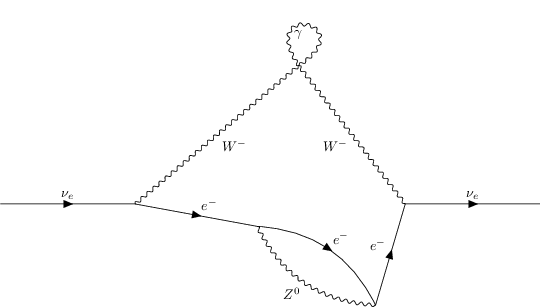

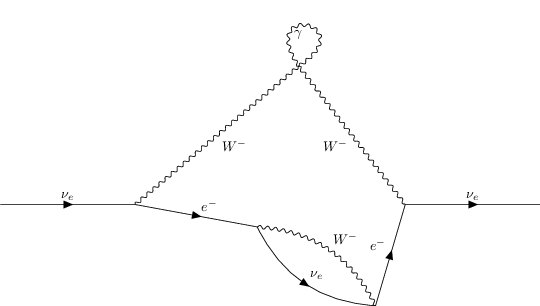

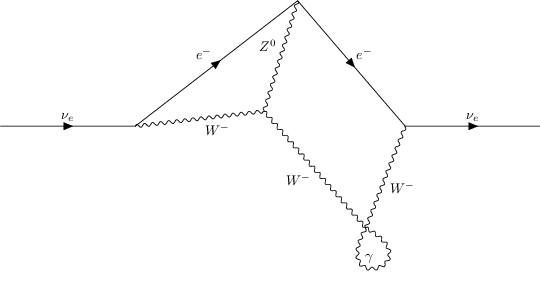

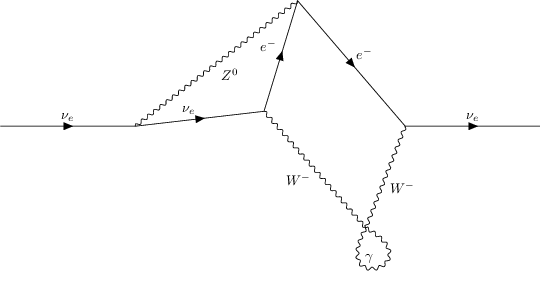

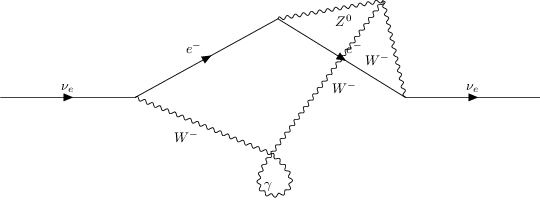

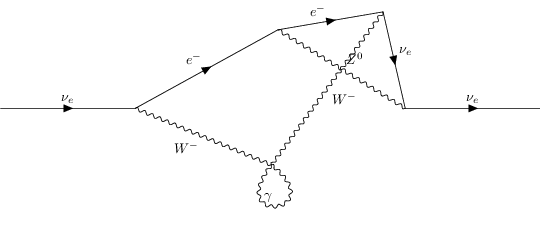

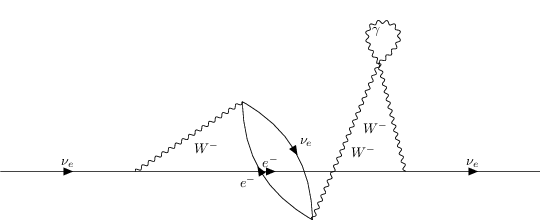

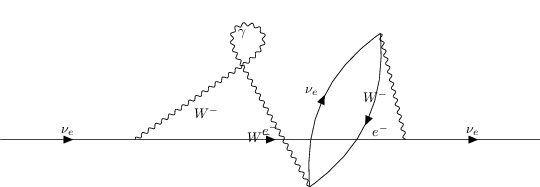

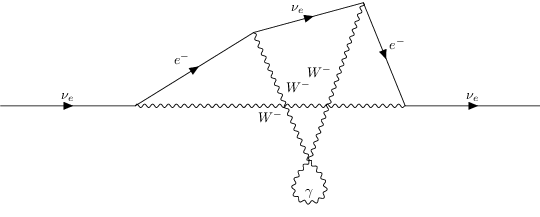

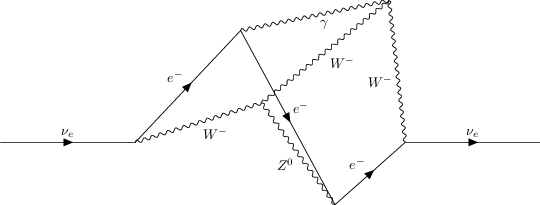

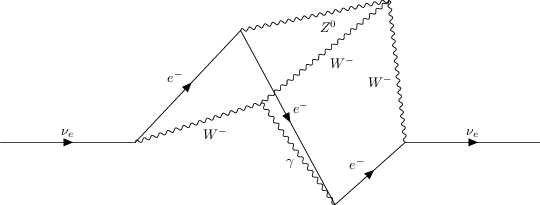

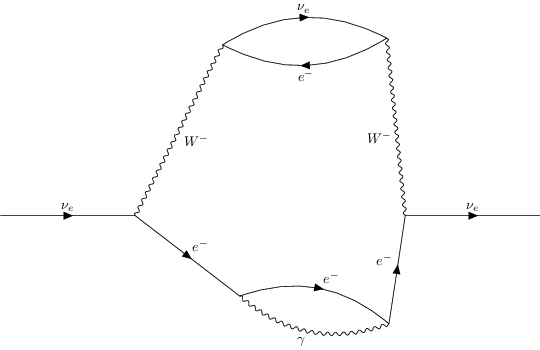

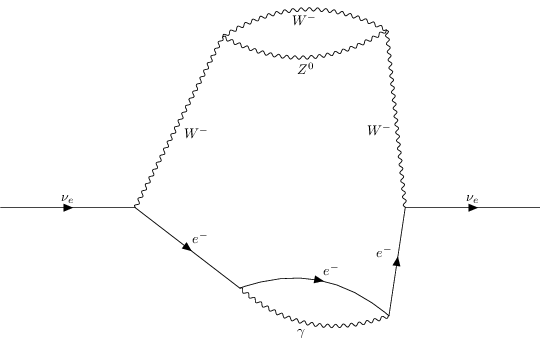

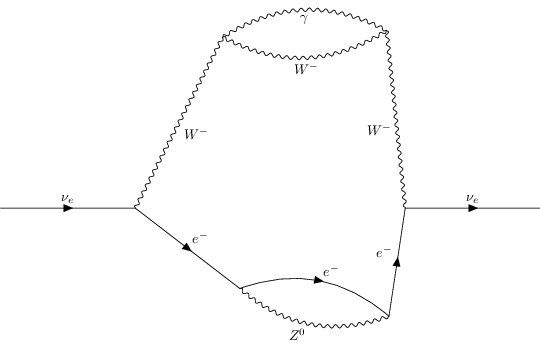

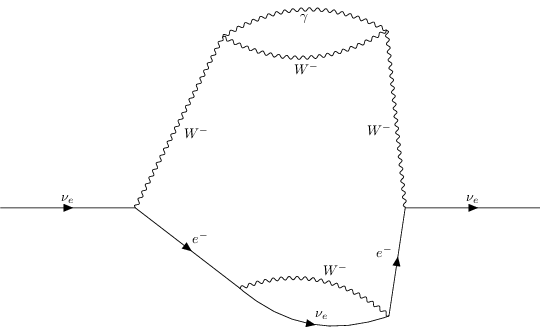

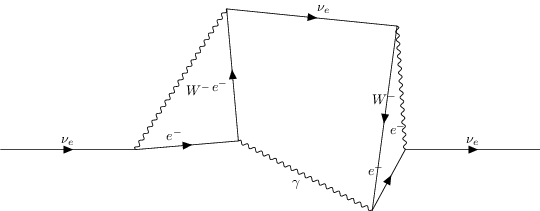

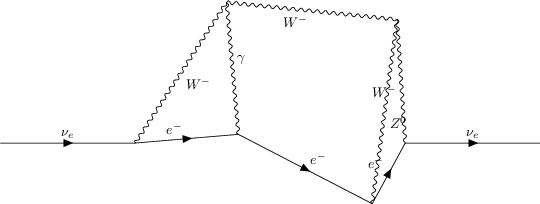

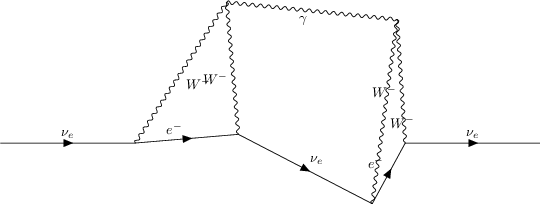

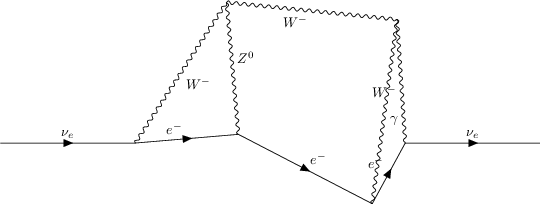

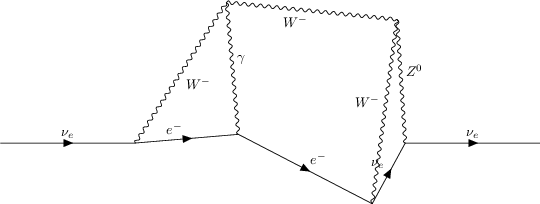

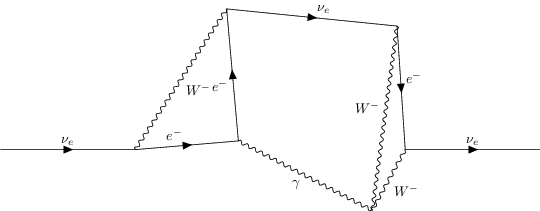

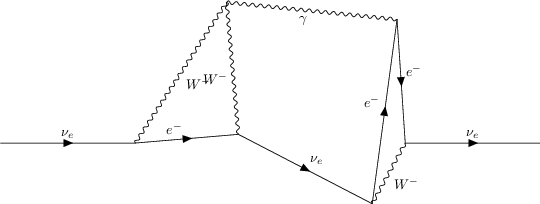

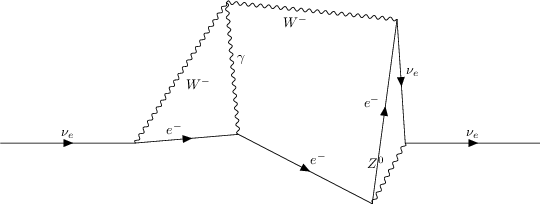

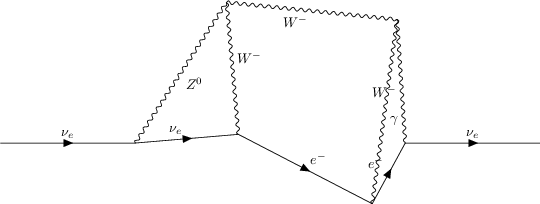

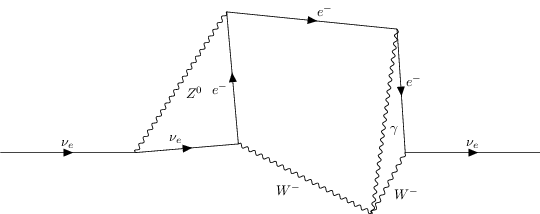

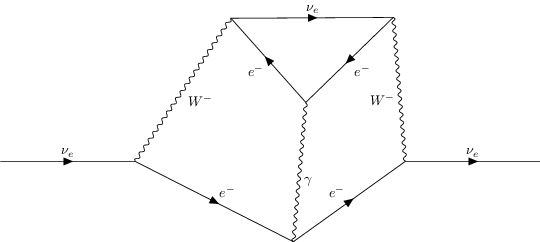

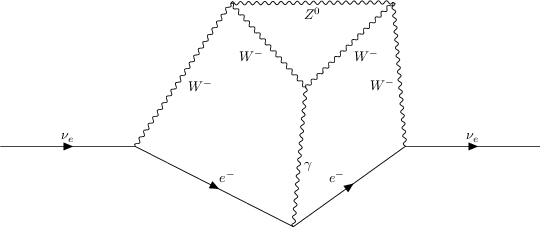

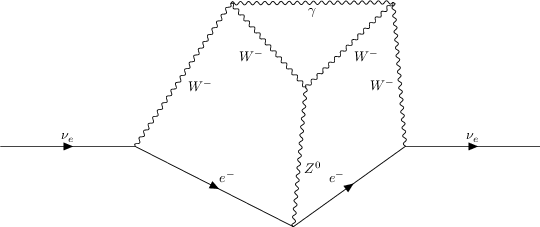

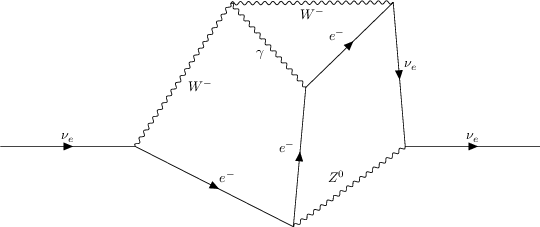

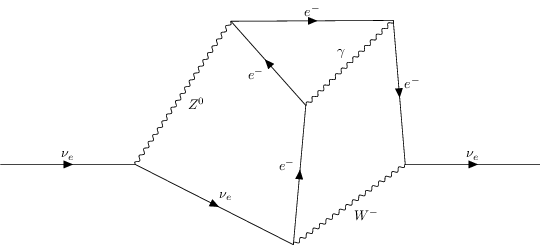

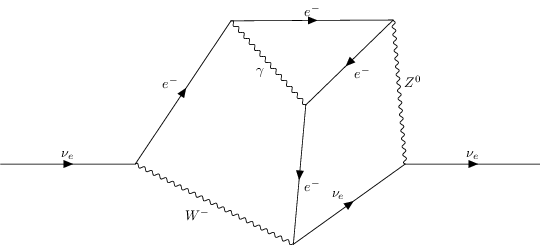

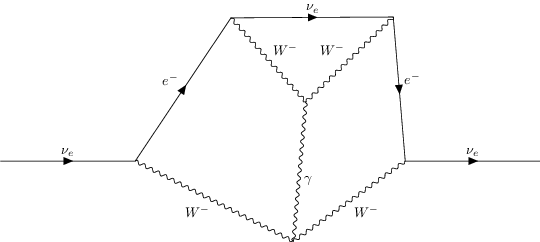

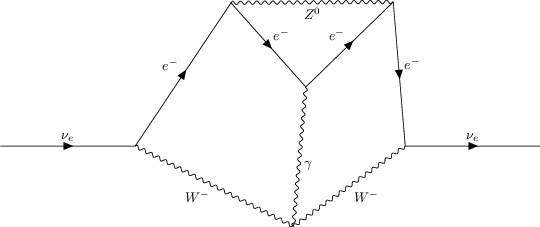

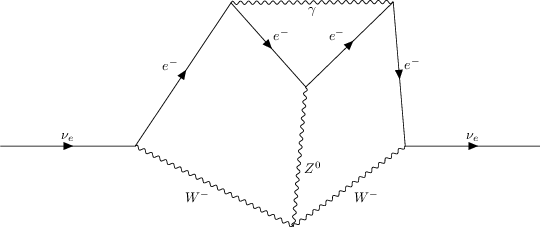

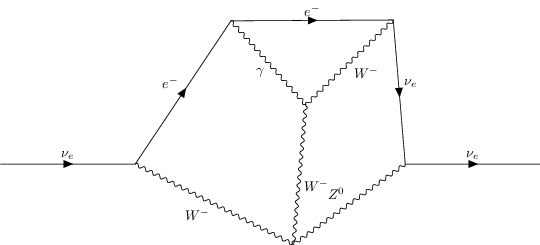

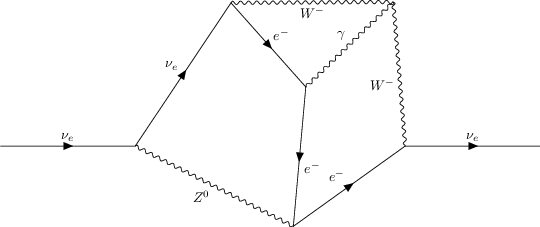

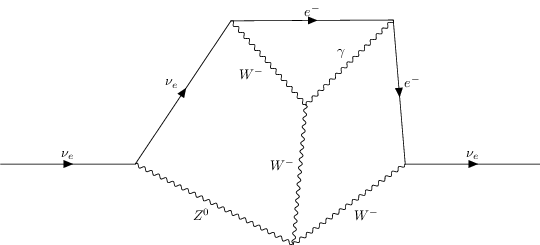

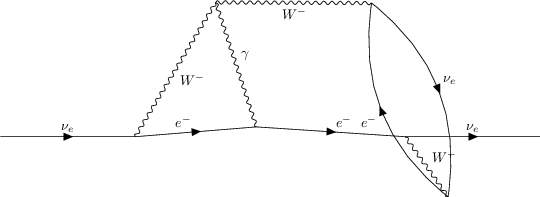

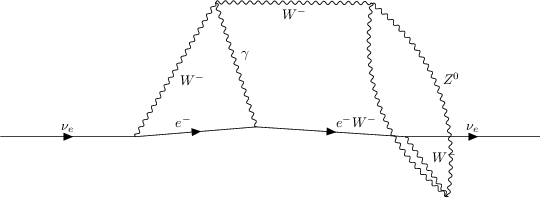

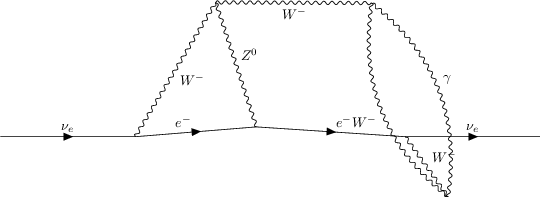

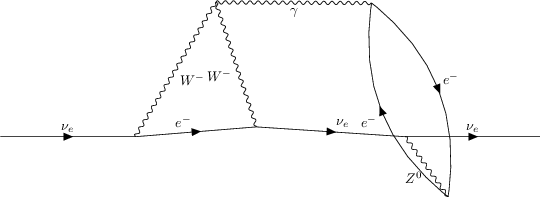

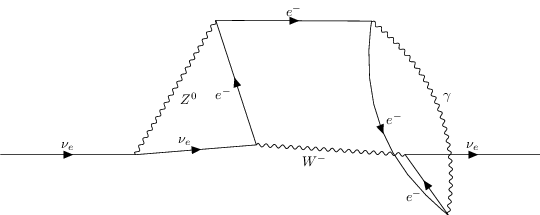

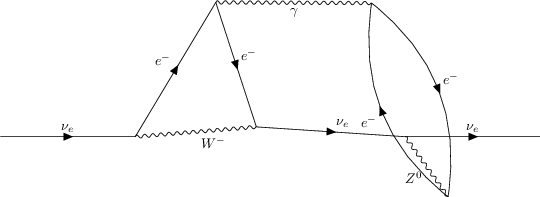

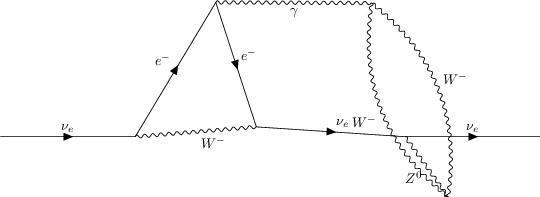

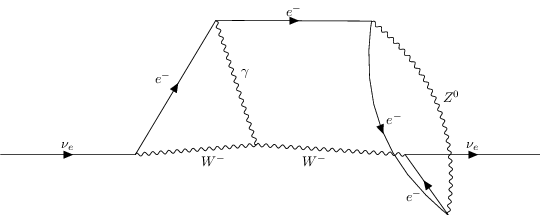

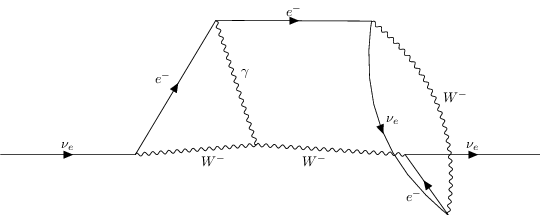

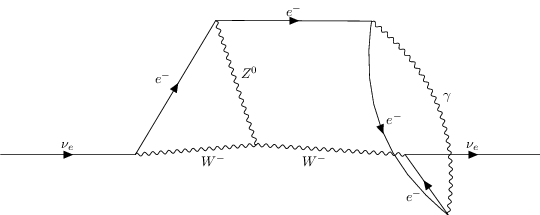

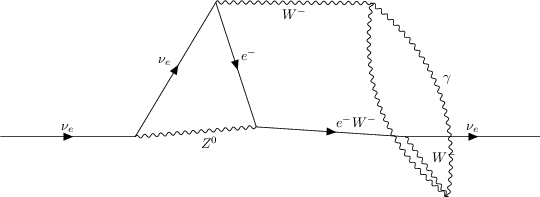

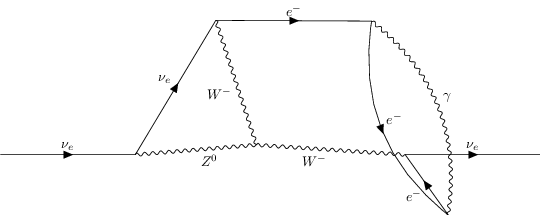

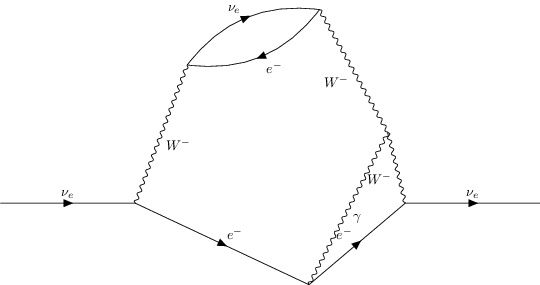

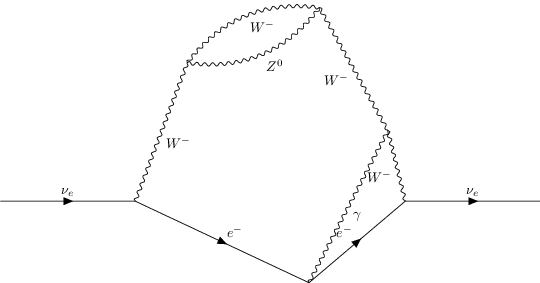

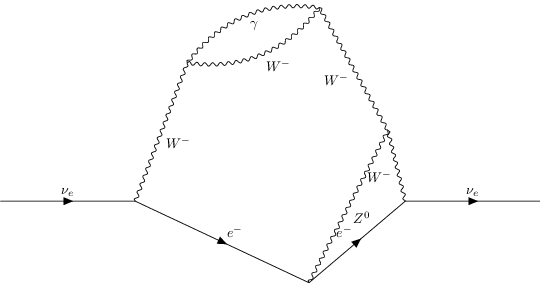

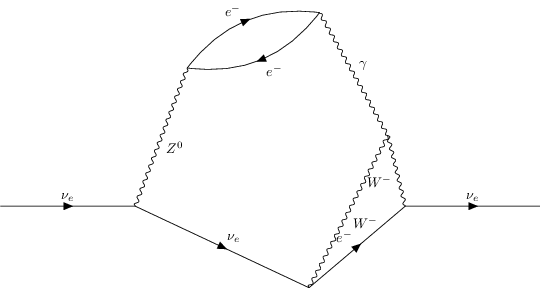

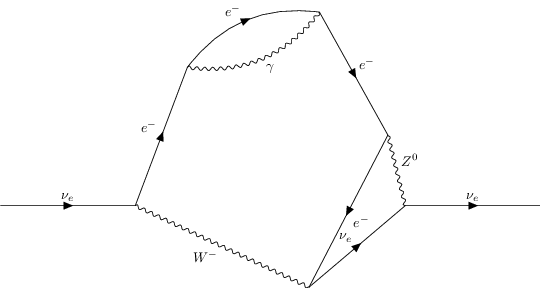

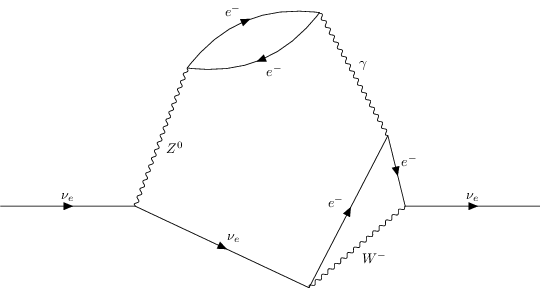

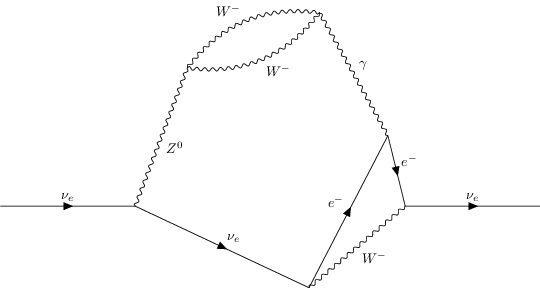

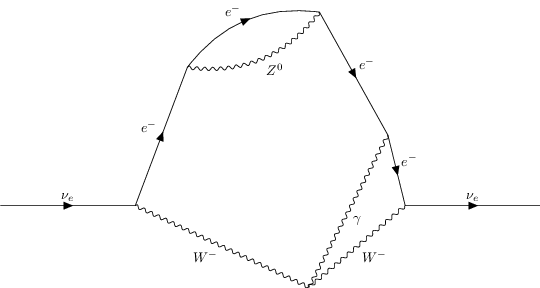

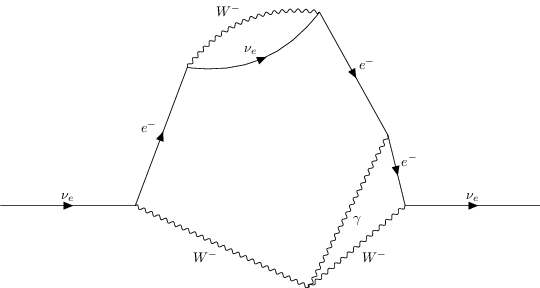

In [ ]:
from pathlib import Path
import subprocess
import shlex

from xsdata.formats.dataclass.parsers import XmlParser
from pyfeyn2.render.latex.feynmp import FeynmpRender
from pyfeyn2.render.latex.tikzfeynman import TikzFeynmanRender
from pyfeyn2.render.pyx.pyxrender import PyxRender
from pyfeyn2.feynmandiagram import FeynML

from pyfeyn2.auto.bend import auto_bend
from pyfeyn2.auto.label import auto_label
from pyfeyn2.auto.position import feynman_adjust_points

subprocess.call(shlex.split(f'qgraf {dat}'))
xml_string = Path(output).read_text()
parser = XmlParser()
fml = parser.from_string(xml_string, FeynML)

def filter_diag(d):
    count = 0
    ecount = 0
    for p in d.propagators:
        if p.pdgid == 22:
            count +=1
        if p.pdgid == 11:
            ecount +=1
    if count ==1 and ecount >=2:
        return True
    return False

ccount=0 
for d in fml.diagrams:
    if filter_diag(d):
        ccount +=1
print("single photon diags", ccount)

for d in fml.diagrams:
    if filter_diag(d):
        ccount +=1
        d.legs[0].with_xy(-2,0)
        d.legs[1].with_xy(2,0)
        d.get_vertex(d.legs[0].target).with_xy(-1,0)
        d.get_vertex(d.legs[1].target).with_xy(1,0)
        d = feynman_adjust_points(d,size=15,override_vertices=False)
        auto_bend(d)
        auto_label(d.propagators)
        auto_label(d.legs)
        #print(d)
        t = TikzFeynmanRender(d)
        #print(t.get_src())
        t.render(show=True)
        #break

In [ ]:
print(xml_string)